In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath("./"))

import pickle
import torch
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from nnfabrik.builder import get_data, get_model
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import ImageColor
from sensorium.utility.measure_helpers import ColorMap2D, get_base_colormap, get_color

In [2]:
def set_xticks(
    axis,
    ticks_loc,
    ticks = None,
    label = "",
    tick_fontsize = None,
    label_fontsize = None,
):
    axis.set_xticks(ticks_loc)
    if ticks is None:
        ticks = ticks_loc
    axis.set_xticklabels(ticks, fontsize=tick_fontsize)
    if label:
        axis.set_xlabel(label, fontsize=label_fontsize)

def set_yticks(
    axis,
    ticks_loc,
    ticks = None,
    label = "",
    tick_fontsize = None,
    label_fontsize = None,
):
    axis.set_yticks(ticks_loc)
    if ticks is None:
        ticks = ticks_loc
    axis.set_yticklabels(ticks, fontsize=tick_fontsize)
    if label:
        axis.set_ylabel(label, fontsize=label_fontsize)
        
def set_ticks_params(
    axis, length = 3, pad = 2
):
    axis.tick_params(axis="both", which="both", length=length, pad=pad, colors="black")

In [3]:
datasets = ["pretrain_21067-10-18", "pretrain_23343-5-17", "pretrain_22846-10-16",
            "pretrain_23656-14-22", "pretrain_23964-4-22", "sensorium+_27204-5-13",
            "sensorium_26872-17-20"]
# as filenames, we'll select all 7 datasets
filenames = [f"../dataset/{dataset}" for dataset in datasets]

model_n = 10
dataset_fn = 'MyDataloader.static_loaders'
dataset_config = {'paths': filenames,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'add_behavior_as_channels': False,
                 'batch_size': 128,
                 'scale': None,
                 }

dataloaders = get_data(dataset_fn, dataset_config)

model_fn = 'models.stacked_core_full_gauss_readout'
model_config = {'pad_input': False,
  'layers': 4,
  'input_kern': 9,
  'gamma_input': 6.3831,
  'gamma_readout': 0.0076,
  'hidden_kern': 7,
  'hidden_channels': 128,
  'depth_separable': True,
  'grid_mean_predictor': {'type': 'cortex',
   'input_dimensions': 2,
   'hidden_layers': 1,
   'hidden_features': 30,
   'final_tanh': True},
  'init_sigma': 0.1,
  'init_mu_range': 0.3,
  'gauss_type': 'full',
  'shifter': False,
  'stack': -1,
}

models = []
for i in range(1, model_n+1):
    model = get_model(model_fn=model_fn,
                    model_config=model_config,
                    dataloaders=dataloaders,
                    seed=314,)
    model.load_state_dict(torch.load(f"./model_checkpoints/generalization_model.{i}.pth"));
    model.eval();
    models.append(model)

[NeuroNormalizer(not ), AddCenteringImage, AddBoundingBoxes, Subsample(n=8372), ToTensor]
[NeuroNormalizer(not ), AddCenteringImage, AddBoundingBoxes, Subsample(n=7334), ToTensor]
[NeuroNormalizer(not ), AddCenteringImage, AddBoundingBoxes, Subsample(n=7344), ToTensor]
[NeuroNormalizer(not ), AddCenteringImage, AddBoundingBoxes, Subsample(n=8107), ToTensor]
[NeuroNormalizer(not ), AddCenteringImage, AddBoundingBoxes, Subsample(n=8098), ToTensor]
[NeuroNormalizer(not ), AddCenteringImage, AddBoundingBoxes, Subsample(n=7538), ToTensor]
[NeuroNormalizer(not ), AddCenteringImage, AddBoundingBoxes, Subsample(n=7776), ToTensor]


In [4]:
rgb_colors = [
    ImageColor.getcolor(i, "RGB")
    for i in ["#ef476f", "#ffd166", "#118ab2", "#073b4c"]
]
img = get_base_colormap(*rgb_colors, interpolation="smooth")

# instantiate 2D Colormap Class with the base colormap
Cmap_2D = ColorMap2D(img)

In [5]:
datasets = ["pretrain_21067-10-18", "pretrain_23343-5-17", "pretrain_22846-10-16",
            "pretrain_23656-14-22", "pretrain_23964-4-22"]
data_keys = [key.split("_")[1] for key in datasets]

plot_info_df = pd.DataFrame()
for data_key in data_keys:
    # readout positions
    readout_pos = [models[i].readout[data_key].mu.squeeze().detach().cpu().numpy() for i in range(10)]
    readout_pos = pd.DataFrame(np.mean(readout_pos, axis=0))
    readout_pos.columns = ["readout_x", "readout_y"]
    
    # cell positions
    coordinates = pd.DataFrame(dataloaders["train"][data_key].dataset.neurons.cell_motor_coordinates)
    coordinates.columns = ["cell_x", "cell_y", "cell_z"]
    
    # color rgb info
    rgb = Cmap_2D(*readout_pos[["readout_x", "readout_y"]].values.T)
    rgb = pd.DataFrame(rgb, columns=["r", "g", "b"])
    
    # combine
    plot_info = pd.concat([coordinates, readout_pos, rgb], axis=1)
    plot_info["data_key"] = data_key
    plot_info_df = pd.concat([plot_info_df, plot_info], axis=0)

In [6]:
def ceil(value: float, precision: int = 0):
    return np.true_divide(np.ceil(value * 10**precision), 10**precision)
def floor(value: float, precision: int = 0):
    return np.true_divide(np.floor(value * 10**precision), 10**precision)

positions = plot_info_df[["readout_x", "readout_y"]].values
xmin, xmax = floor(np.min(positions[:, 0]), 1), ceil(np.max(positions[:, 0]), 1)
ymin, ymax = floor(np.min(positions[:, 1]), 1), ceil(np.max(positions[:, 1]), 1)

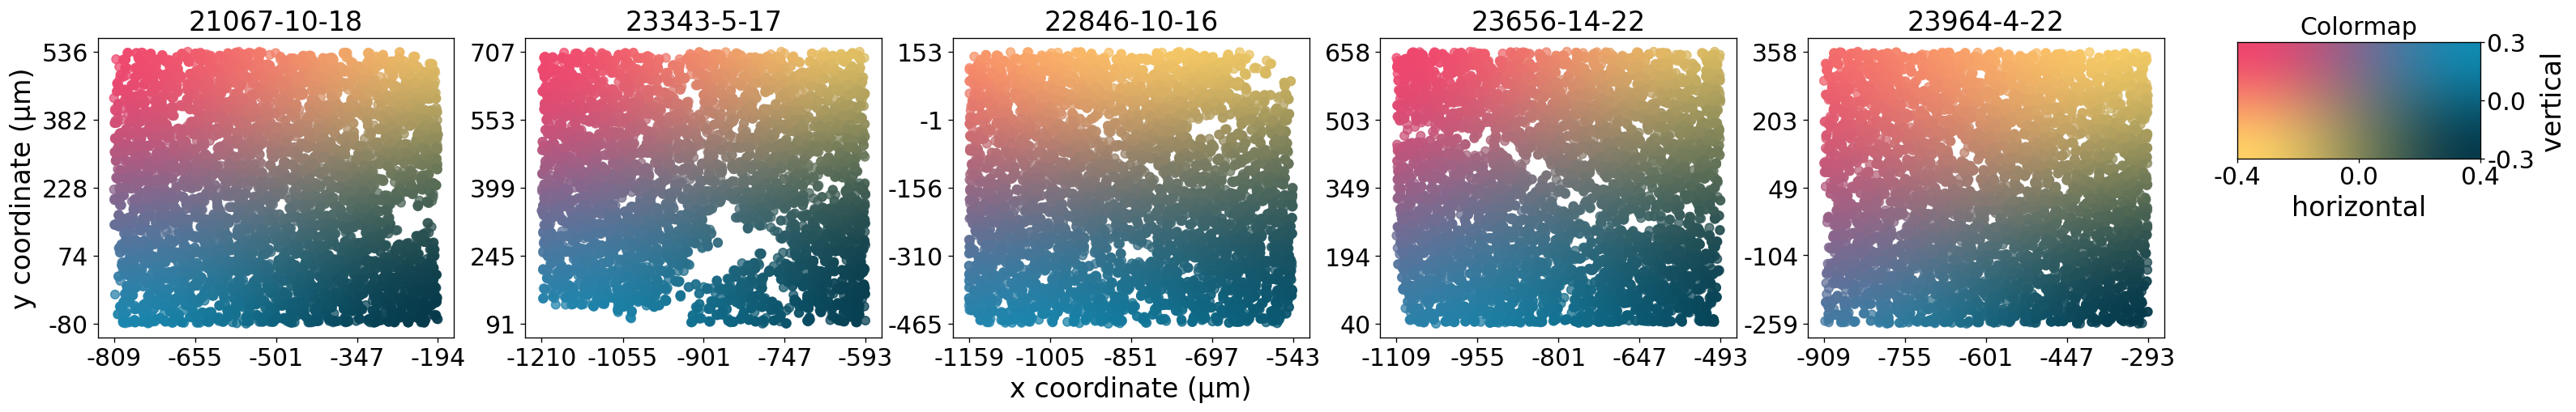

In [7]:
tick_fontsize, label_fontsize = 18, 20

figure, ax = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(25, 4),
    dpi=120,
    facecolor="#ffffff",
)

for i, data_key in enumerate(data_keys):
    coordinates = plot_info_df[plot_info_df.data_key == data_key][["cell_x", "cell_y"]].values
    rgb = plot_info_df[plot_info_df.data_key == data_key][["r", "g", "b"]].values

    # Show Anatomical Positions
    ax[i].scatter(
        coordinates[:, 0],
        coordinates[:, 1],
        c=rgb.squeeze(),
        alpha=0.75,
        s=40,
    )
    ax[i].set_title(
        f"{data_key}", fontsize=20
    )
    set_xticks(
        axis=ax[i],
        ticks_loc=np.linspace(
            np.min(coordinates[:, 0]), np.max(coordinates[:, 0]), 5
        ).astype(int),
        label="x coordinate (μm)" if i == 2 else "",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    set_yticks(
        axis=ax[i],
        ticks_loc=np.linspace(
            np.min(coordinates[:, 1]), np.max(coordinates[:, 1]), 5
        ).astype(int),
        label="y coordinate (μm)" if i == 0 else "",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )

plt.subplots_adjust(left=0.1, right=0.95)

x_range = np.linspace(xmin, xmax, 3)
y_range = np.linspace(ymin, ymax, 3)
# # show 2D Colormap
bar_ax = figure.add_axes([0.98, 0.57, 0.1, 0.3])
bar_ax.imshow(
    Cmap_2D.generate_cbar(),
    extent=(xmin, xmax, ymin, ymax),
    aspect="auto",
    origin="lower",
)
bar_ax.set_title("Colormap", fontsize=18)
set_xticks(
    axis=bar_ax,
    ticks_loc=x_range,
    ticks=x_range.round(2),
    label="horizontal",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
set_yticks(
    axis=bar_ax,
    ticks_loc=y_range,
    ticks=y_range.round(2)[::-1],
    label="vertical",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
bar_ax.yaxis.tick_right()
bar_ax.yaxis.set_label_position("right")
bar_ax.invert_yaxis()
set_ticks_params(axis=bar_ax)


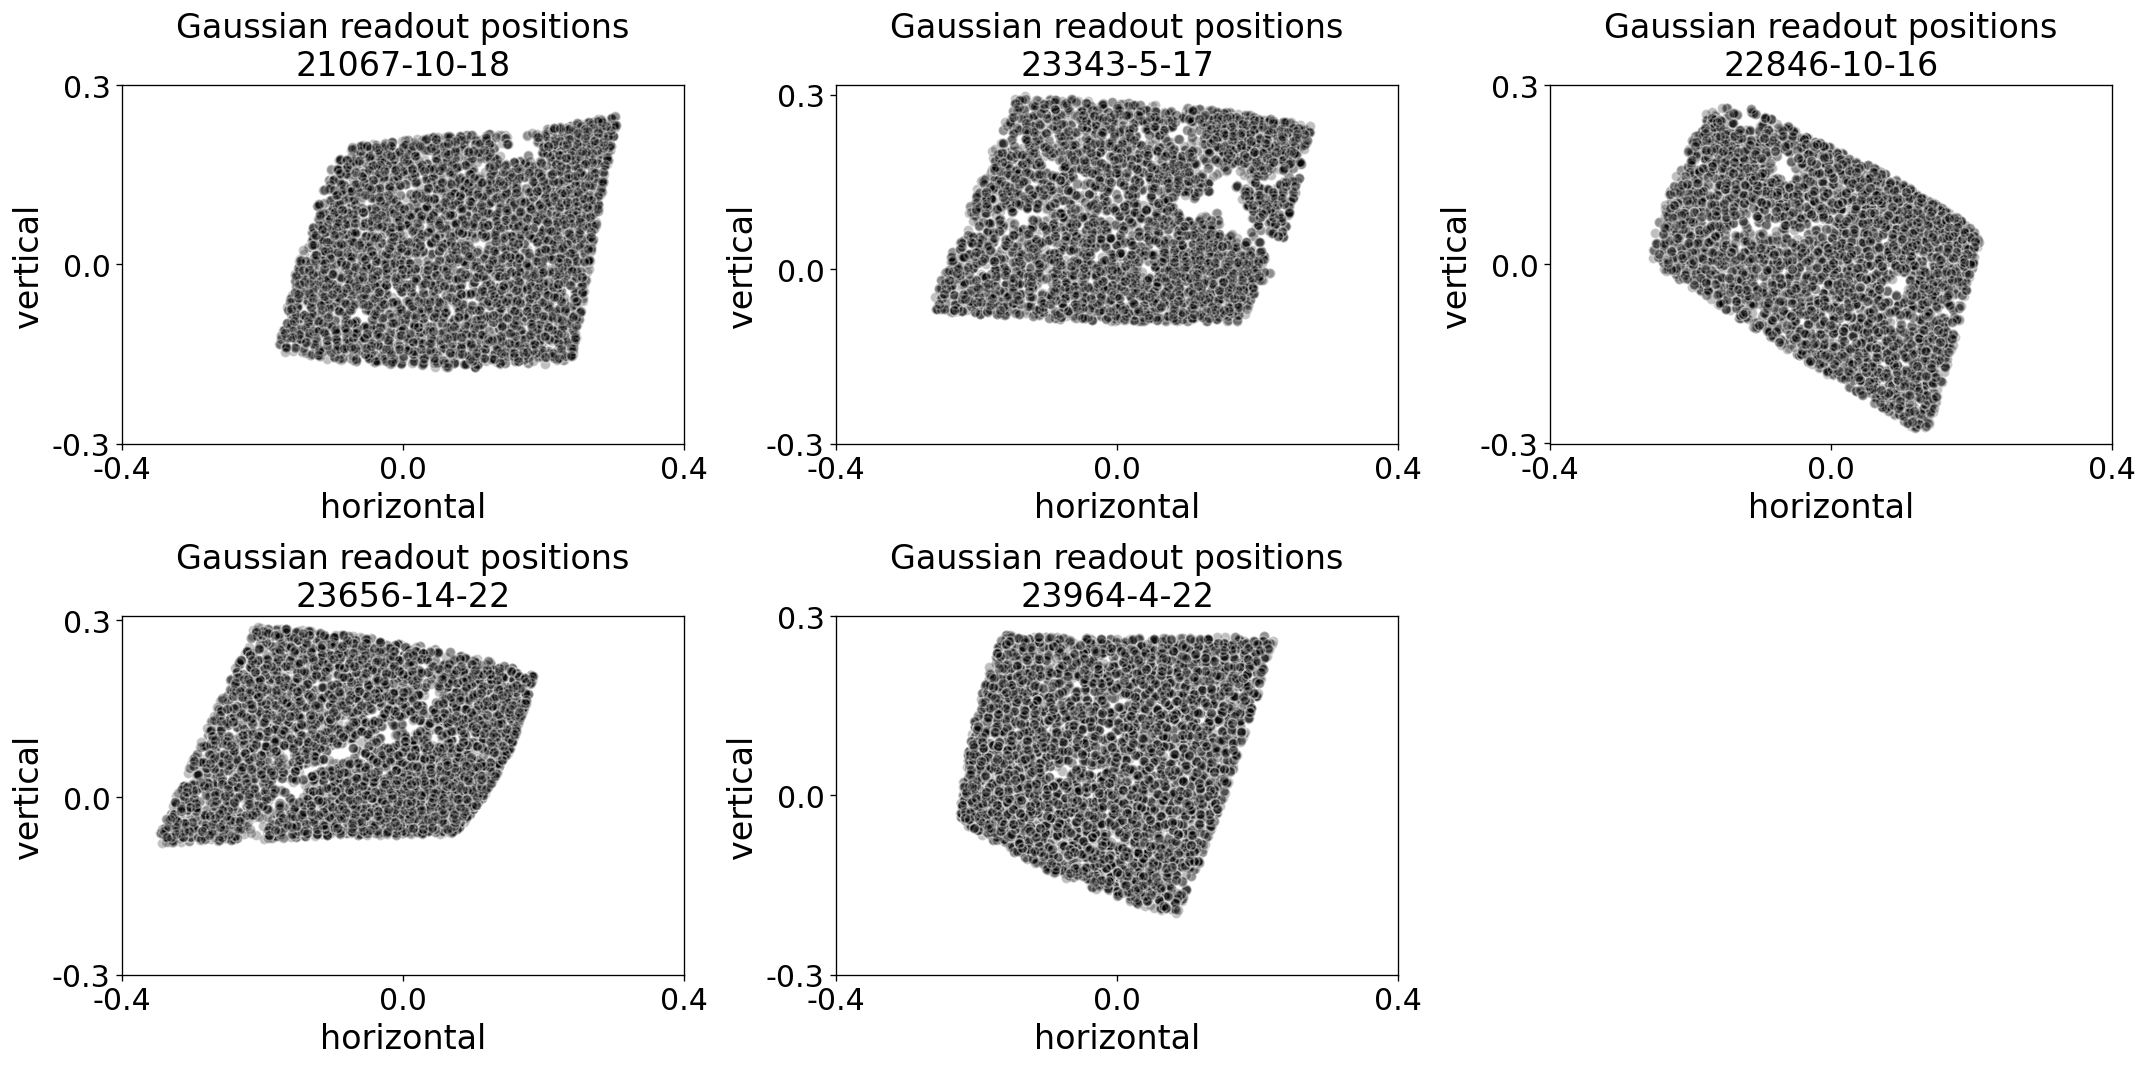

In [122]:
readout_pos = {}
for data_key in data_keys:
    readout_pos[data_key] = np.mean([models[i].readout[data_key].mu.squeeze().detach().cpu().numpy() for i in range(10)], axis=0)
    
figure, ax = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(18, 9),
    dpi=120,
    facecolor="#ffffff",
)

for i, data_key in enumerate(data_keys):
    # Show Anatomical Positions
    positions = plot_info_df[plot_info_df.data_key == data_key][["readout_x", "readout_y"]].values
    
    ax[i//3, i%3].scatter(*positions.T, alpha=0.25, c="k", edgecolor="w")
    ax[i//3, i%3].set_title(
        f"Gaussian readout positions\n{data_key}", fontsize=20
    )
    set_xticks(
        axis=ax[i//3, i%3],
        ticks_loc=x_range,
        ticks=x_range.round(2),
        label="horizontal",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    set_yticks(
        axis=ax[i//3, i%3],
        ticks_loc=y_range,
        ticks=y_range.round(2),
        label="vertical",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    
ax[1, 2].axis("off")
plt.tight_layout()

In [96]:
# retinotopic plot for all models

In [111]:
plot_info_df = pd.DataFrame()
for data_key in data_keys:
    for i in range(10):
        # readout positions
        readout_pos = pd.DataFrame(models[i].readout[data_key].mu.squeeze().detach().cpu().numpy())
        readout_pos.columns = ["readout_x", "readout_y"]
        # print(data_key, i, readout_pos.min(), readout_pos.max())
        
        # cell positions
        coordinates = pd.DataFrame(dataloaders["train"][data_key].dataset.neurons.cell_motor_coordinates)
        coordinates.columns = ["cell_x", "cell_y", "cell_z"]
        
        coordinates_norm = coordinates - coordinates.mean(axis=0)
        coordinates_norm = coordinates_norm / np.abs(coordinates_norm).max(axis=0)
        coordinates_norm.columns = ["cell_x_norm", "cell_y_norm", "cell_z_norm"]
        
        # color rgb info
        rgb = Cmap_2D(*readout_pos[["readout_x", "readout_y"]].values.T)
        rgb = pd.DataFrame(rgb, columns=["r", "g", "b"])
        
        # combine
        plot_info = pd.concat([coordinates, coordinates_norm, readout_pos, rgb], axis=1)
        plot_info["data_key"] = data_key
        plot_info["model"] = i+1
        plot_info_df = pd.concat([plot_info_df, plot_info], axis=0)
        
positions = plot_info_df[["readout_x", "readout_y"]].values
xmin, xmax = floor(np.min(positions[:, 0]), 1), ceil(np.max(positions[:, 0]), 1)
ymin, ymax = floor(np.min(positions[:, 1]), 1), ceil(np.max(positions[:, 1]), 1)

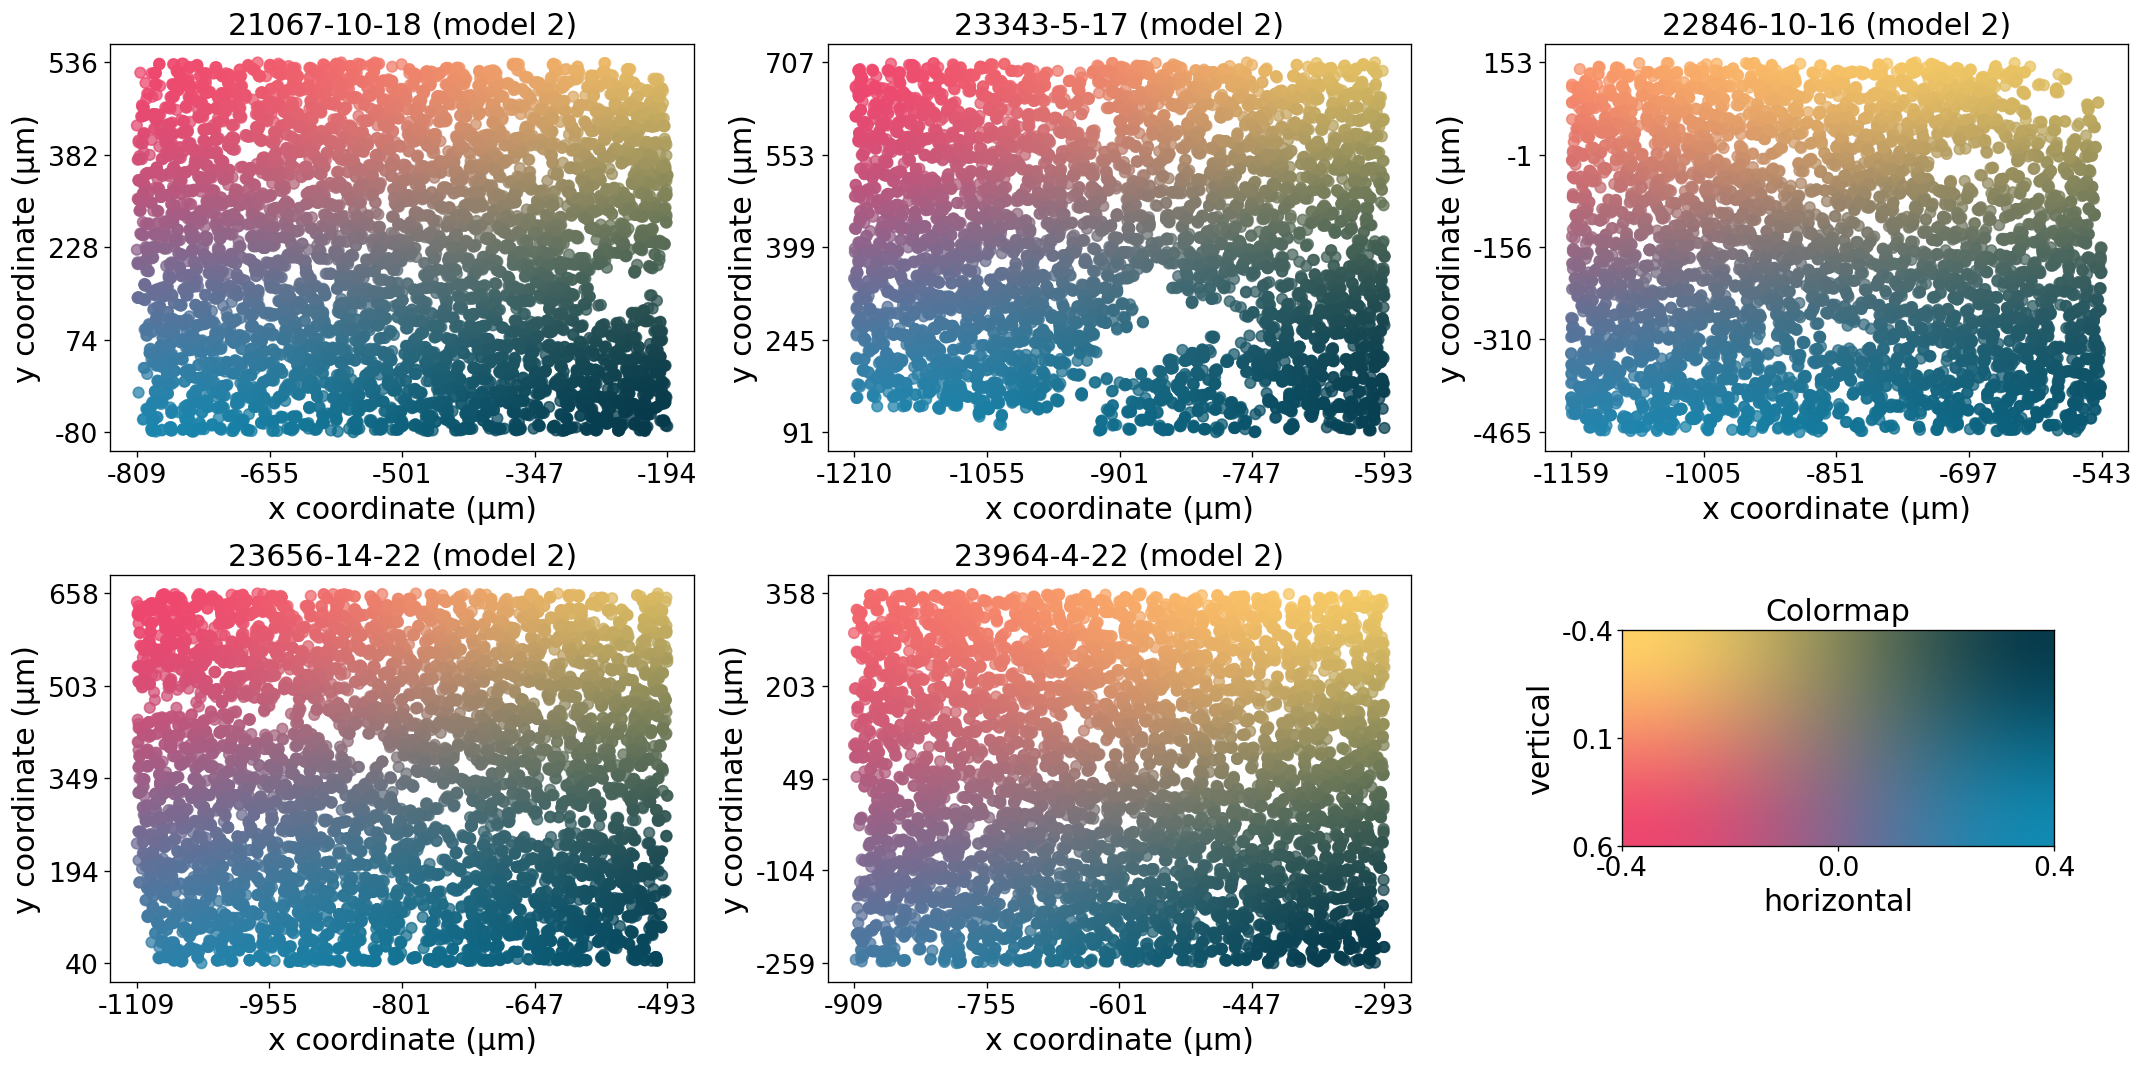

In [115]:
model = 2
tick_fontsize, label_fontsize = 16, 18

figure, ax = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(18, 9),
    dpi=120,
    facecolor="#ffffff",
)

for i, data_key in enumerate(data_keys):
    coordinates = plot_info_df[(plot_info_df.data_key == data_key) & (plot_info_df.model == model)][["cell_x", "cell_y"]].values
    rgb = plot_info_df[(plot_info_df.data_key == data_key) & (plot_info_df.model == model)][["r", "g", "b"]].values

    # Show Anatomical Positions
    ax[i//3, i%3].scatter(
        coordinates[:, 0],
        coordinates[:, 1],
        c=rgb.squeeze(),
        alpha=0.75,
        s=40,
    )
    ax[i//3, i%3].set_title(
        f"{data_key} (model {model})", fontsize=18
    )
    set_xticks(
        axis=ax[i//3, i%3],
        ticks_loc=np.linspace(
            np.min(coordinates[:, 0]), np.max(coordinates[:, 0]), 5
        ).astype(int),
        label="x coordinate (μm)",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )
    set_yticks(
        axis=ax[i//3, i%3],
        ticks_loc=np.linspace(
            np.min(coordinates[:, 1]), np.max(coordinates[:, 1]), 5
        ).astype(int),
        label="y coordinate (μm)",
        tick_fontsize=tick_fontsize,
        label_fontsize=label_fontsize,
    )

ax[1, 2].axis("off")
# plt.subplots_adjust(left=0.1, right=0.9)

x_range = np.linspace(xmin, xmax, 3)
y_range = np.linspace(ymin, ymax, 3)
# # show 2D Colormap
bar_ax = figure.add_axes([0.7538, 0.21, 0.2, 0.2])
bar_ax.imshow(
    Cmap_2D.generate_cbar(),
    extent=(xmin, xmax, ymin, ymax),
    aspect="auto",
    origin="lower",
)
bar_ax.set_title("Colormap", fontsize=18)
set_xticks(
    axis=bar_ax,
    ticks_loc=x_range,
    ticks=x_range.round(2),
    label="horizontal",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
set_yticks(
    axis=bar_ax,
    ticks_loc=y_range,
    ticks=y_range.round(2)[::-1],
    label="vertical",
    tick_fontsize=tick_fontsize,
    label_fontsize=label_fontsize,
)
ax[1, 2].yaxis.tick_right()
ax[1, 2].yaxis.set_label_position("right")
ax[1, 2].invert_yaxis()
set_ticks_params(axis=bar_ax)

plt.tight_layout()